In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

df = pd.read_csv("../data/merged_data.csv", parse_dates=["datetime"])
df = df.sort_values("datetime")
df["hour"] = df["datetime"].dt.hour
df["is_daytime"] = ((df["hour"] >= 7) & (df["hour"] < 19)).astype(int)

df = df.drop(columns=["hour"])

df["sin_hour"] = np.sin(2 * np.pi * df["datetime"].dt.hour / 24)
df["cos_hour"] = np.cos(2 * np.pi * df["datetime"].dt.hour / 24)
df["price_lag_1h"] = df["price_EUR_MWh"].shift(1)

df = df.dropna()

# features = [
#     "temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation",
#     "quantity_biomass", "quantity_fossil_gas", "quantity_fossil_hard_coal",
#     "quantity_hydro_run_of_river", "quantity_nuclear", "quantity_solar",
#     "quantity_waste", "quantity_wind_offshore", "quantity_wind_onshore",
#     "quantity_other", "price_lag_1h", "is_daytime", "sin_hour", "cos_hour", "quantity_MW"
# ]

features = [
    "temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation", "quantity_solar",
    "quantity_other", "price_lag_1h", "is_daytime", "sin_hour", "cos_hour", "quantity_MW"
]
target = "price_EUR_MWh"

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X = scaler_x.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

# # Splitting indices before scaling
# val_days = 30
# val_size = val_days * 24

# train_df = df.iloc[:-val_size]
# val_df = df.iloc[-val_size:]

# # Fit scalers ONLY on training data
# scaler_x = StandardScaler()
# scaler_y = StandardScaler()

# scaler_x.fit(train_df[features])
# scaler_y.fit(train_df[[target]])

# # Transform entire dataset safely
# X = scaler_x.transform(df[features])
# y = scaler_y.transform(df[[target]])


In [3]:
class TimeSeriesDataset(Dataset):
    """
    Custom Dataset for time series data with fixed sequence length.
    """
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        return (
            self.X[idx:idx+self.seq_len],
            self.y[idx+self.seq_len]
        )

class DSSM(nn.Module):
    """
    Deep Structured State Model (DSSM) for time series forecasting.
    This model uses a GRU for state representation and a feedforward network for observation modeling.
    """
    def __init__(self, input_dim, state_dim, hidden_dim):
        super().__init__()
        self.rnn = nn.GRU(input_dim, state_dim, batch_first=True, num_layers=2, dropout=0.15 )
        self.obs_model = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        state_seq, _ = self.rnn(x)
        output = self.obs_model(state_seq[:, -1, :])
        return output.squeeze(-1)

In [32]:
# Splitting the dataset into training and validation sets
# Assuming the data is hourly and we want to validate on the last 30 days
sequence_length = 24 # 24 hours = 1 day
val_days = 30
val_size = val_days * 24

train_X = X[:-val_size]
train_y = y[:-val_size]
val_X = X[-val_size - sequence_length:]
val_y = y[-val_size - sequence_length:]

train_dataset = TimeSeriesDataset(train_X, train_y, sequence_length)
val_dataset = TimeSeriesDataset(val_X, val_y, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model, optimizer, and loss function
model = DSSM(input_dim=X.shape[1], state_dim=64, hidden_dim=128)
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.L1Loss()
# criterion = nn.HuberLoss()
# criterion = nn.SmoothL1Loss()

# Training the model
n_epochs = 30
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

model.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    for x, t in train_loader:
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, t.squeeze(-1))
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, t in val_loader:
            preds = model(x)
            loss = criterion(preds, t.squeeze(-1))
            val_loss += loss.item()
    model.train()

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

/Users/minhgou/Desktop/Zurich/First Year/Advanced Machine Learning/aml2025-group-15/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.3328, Val Loss: 0.1729
Epoch 2, Train Loss: 0.2212, Val Loss: 0.1700
Epoch 3, Train Loss: 0.2051, Val Loss: 0.1625
Epoch 4, Train Loss: 0.1951, Val Loss: 0.1608
Epoch 5, Train Loss: 0.1808, Val Loss: 0.1589
Epoch 6, Train Loss: 0.1754, Val Loss: 0.1531
Epoch 7, Train Loss: 0.1684, Val Loss: 0.1503
Epoch 8, Train Loss: 0.1658, Val Loss: 0.1481
Epoch 9, Train Loss: 0.1688, Val Loss: 0.1489
Epoch 10, Train Loss: 0.1795, Val Loss: 0.1511
Epoch 11, Train Loss: 0.1655, Val Loss: 0.1468
Epoch 12, Train Loss: 0.1646, Val Loss: 0.1438
Epoch 13, Train Loss: 0.1596, Val Loss: 0.1434
Epoch 14, Train Loss: 0.1581, Val Loss: 0.1398
Epoch 15, Train Loss: 0.1579, Val Loss: 0.1415
Epoch 16, Train Loss: 0.1737, Val Loss: 0.1418
Epoch 17, Train Loss: 0.1558, Val Loss: 0.1386
Epoch 18, Train Loss: 0.1595, Val Loss: 0.1372
Epoch 19, Train Loss: 0.1511, Val Loss: 0.1354
Epoch 20, Train Loss: 0.1523, Val Loss: 0.1363
Epoch 21, Train Loss: 0.1521, Val Loss: 0.1389
Epoch 22, Train Loss: 

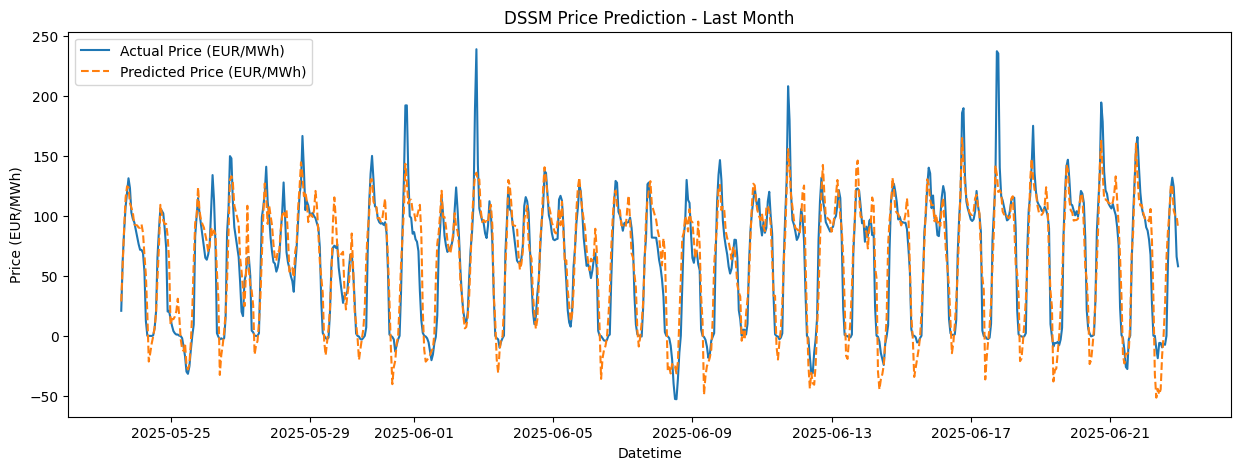

In [33]:
# Evaluation on the last month
model.eval()
all_preds = []
all_actuals = []
with torch.no_grad():
    for x, t in val_loader:
        preds = model(x)
        all_preds.append(preds.numpy())
        all_actuals.append(t.squeeze(-1).numpy())

preds_flat = np.concatenate(all_preds)
actuals_flat = np.concatenate(all_actuals)

preds_inverse = scaler_y.inverse_transform(preds_flat.reshape(-1, 1)).flatten()
actuals_inverse = scaler_y.inverse_transform(actuals_flat.reshape(-1, 1)).flatten()

# Plotting the results for the last month
val_datetimes = df["datetime"].iloc[-val_size:].reset_index(drop=True)

plt.figure(figsize=(15, 5))
plt.plot(val_datetimes, actuals_inverse, label="Actual Price (EUR/MWh)")
plt.plot(val_datetimes, preds_inverse, label="Predicted Price (EUR/MWh)", linestyle="--")
plt.title("DSSM Price Prediction - Last Month")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actuals_inverse, preds_inverse)
mae = mean_absolute_error(actuals_inverse, preds_inverse)

denom = (np.abs(actuals_inverse) + np.abs(preds_inverse)) / 2
non_zero_mask = denom != 0
smape = np.mean(np.abs(actuals_inverse - preds_inverse)[non_zero_mask] / denom[non_zero_mask]) * 100

print(f"Validation Set Metrics:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")


Validation Set Metrics:
MSE: 421.20
MAE: 14.82


In [35]:
block_size = 6
total_blocks = 28

# Results per block
block_metrics = []

for i in range(total_blocks):
    start = i * block_size
    end = (i + 1) * block_size

    block_actuals = actuals_inverse[start:end]
    block_preds = preds_inverse[start:end]

    mse = mean_squared_error(block_actuals, block_preds)
    mae = mean_absolute_error(block_actuals, block_preds)

    denom = (np.abs(block_actuals) + np.abs(block_preds)) / 2
    non_zero_mask = denom != 0
    smape = np.mean(np.abs(block_actuals - block_preds)[non_zero_mask] / denom[non_zero_mask]) * 100

    block_metrics.append({
        "Block": i + 1,
        "Start Hour": start,
        "End Hour": end,
        "MSE": mse,
        "MAE": mae,
        "SMAPE": smape
    })

block_df = pd.DataFrame(block_metrics)

print("\nPer Block Metrics:")
print(block_df.round(2))

# Group into Horizon Tiers
tiers = {
    "Short-term (0–24h)": block_df.iloc[0:4],
    "Medium-term (24–72h)": block_df.iloc[4:12],
    "Long-term (72–168h)": block_df.iloc[12:28]
}

print("\nAggregated Metrics by Horizon Tier:")
for tier_name, tier_df in tiers.items():
    mse_mean = tier_df["MSE"].mean()
    mae_mean = tier_df["MAE"].mean()
    smape_mean = tier_df["SMAPE"].median()
    print(f"\n{tier_name}")
    print(f"MSE: {mse_mean:.2f}")
    print(f"MAE: {mae_mean:.2f}")
    print(f"SMAPE: {smape_mean:.2f}%")


Per Block Metrics:
    Block  Start Hour  End Hour      MSE    MAE       SMAPE
0       1           0         6    36.31   5.61    9.430000
1       2           6        12    52.01   6.15    6.120000
2       3          12        18   487.56  20.43   38.650002
3       4          18        24   172.54  10.29  165.699997
4       5          24        30    93.21   7.35   10.880000
5       6          30        36  1041.12  23.35   57.040001
6       7          36        42   307.91  15.37  168.529999
7       8          42        48    44.15   5.80   51.020000
8       9          48        54   563.70  16.55   72.919998
9      10          54        60   160.91  11.00   13.910000
10     11          60        66   586.35  16.92   16.809999
11     12          66        72   787.63  22.78  165.419998
12     13          72        78   478.53  19.07   23.770000
13     14          78        84   597.26  23.84   53.610001
14     15          84        90   607.70  19.58   67.019997
15     16          9

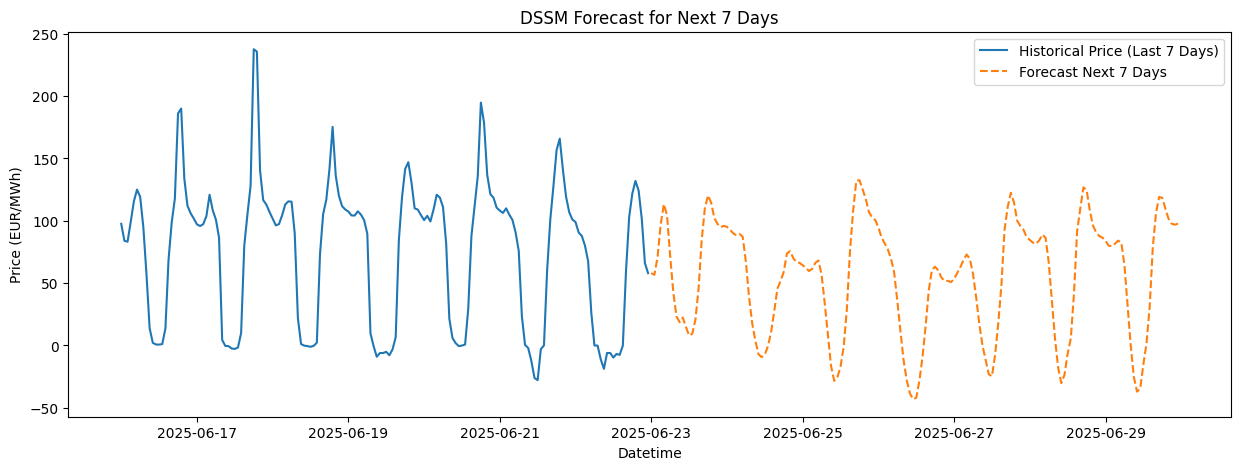

In [36]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

forecast_horizon = 168  # 7 days
sequence_length = 168

# Load weather forecast
weather_df = pd.read_csv("../data/weather_forecast.csv", parse_dates=["datetime"])
weather_df = weather_df.sort_values("datetime").reset_index(drop=True)

# Optional: Scale weather columns now if your model expects scaled weather inputs
weather_features = ["temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation"]
scaler_weather = StandardScaler()
scaler_weather.fit(df[weather_features])  # Fit only on weather columns
# Scale weather forecast
weather_df[weather_features] = scaler_weather.transform(weather_df[weather_features])

# Prepare latest known features
latest_features = df[features].iloc[-sequence_length:].copy()
latest_scaled = scaler_x.transform(latest_features)

input_seq = torch.tensor(latest_scaled, dtype=torch.float32).unsqueeze(0)
current_seq = input_seq.clone()

forecast_scaled = []
forecast_unscaled = []

for i in range(forecast_horizon):
    model.eval()
    with torch.no_grad():
        pred_scaled = model(current_seq).item()  # Model predicts scaled price
        forecast_scaled.append(pred_scaled)

    pred_unscaled = scaler_y.inverse_transform(np.array([[pred_scaled]]))[0, 0]
    forecast_unscaled.append(pred_unscaled)

    shifted_seq = current_seq[:, 1:, :].squeeze(0).numpy()
    next_feature = shifted_seq[-1].copy()

    # Update lag price feature with scaled prediction (model output already scaled)
    idx_lag = features.index('price_lag_1h')
    next_feature[idx_lag] = pred_scaled

    # Generate new datetime
    new_datetime = df["datetime"].iloc[-1] + pd.Timedelta(hours=i + 1)

    # Update time features
    idx_day = features.index('is_daytime')
    next_feature[idx_day] = 1 if 6 <= new_datetime.hour < 20 else 0

    idx_sin = features.index('sin_hour')
    idx_cos = features.index('cos_hour')
    next_feature[idx_sin] = np.sin(2 * np.pi * new_datetime.hour / 24)
    next_feature[idx_cos] = np.cos(2 * np.pi * new_datetime.hour / 24)

    # Inject weather forecast if available
    weather_row = weather_df.loc[weather_df["datetime"] == new_datetime]
    if not weather_row.empty:
        for w_feat in weather_features:
            if w_feat in features:
                idx_w = features.index(w_feat)
                next_feature[idx_w] = weather_row.iloc[0][w_feat]
    else:
        print(f"No weather forecast for {new_datetime}, keeping last known values.")

    # Build new input sequence
    new_seq = np.vstack([shifted_seq, next_feature])
    current_seq = torch.tensor(new_seq, dtype=torch.float32).unsqueeze(0)

# Create forecast datetimes
forecast_datetimes = pd.date_range(
    start=df["datetime"].iloc[-1] + pd.Timedelta(hours=1),
    periods=forecast_horizon,
    freq="h"
)

# Plot historical + forecast
plt.figure(figsize=(15, 5))
plt.plot(df["datetime"].iloc[-7*24:], df["price_EUR_MWh"].iloc[-7*24:], label="Historical Price (Last 7 Days)")
plt.plot(forecast_datetimes, forecast_unscaled, label="Forecast Next 7 Days", linestyle="--")
plt.title("DSSM Forecast for Next 7 Days")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()


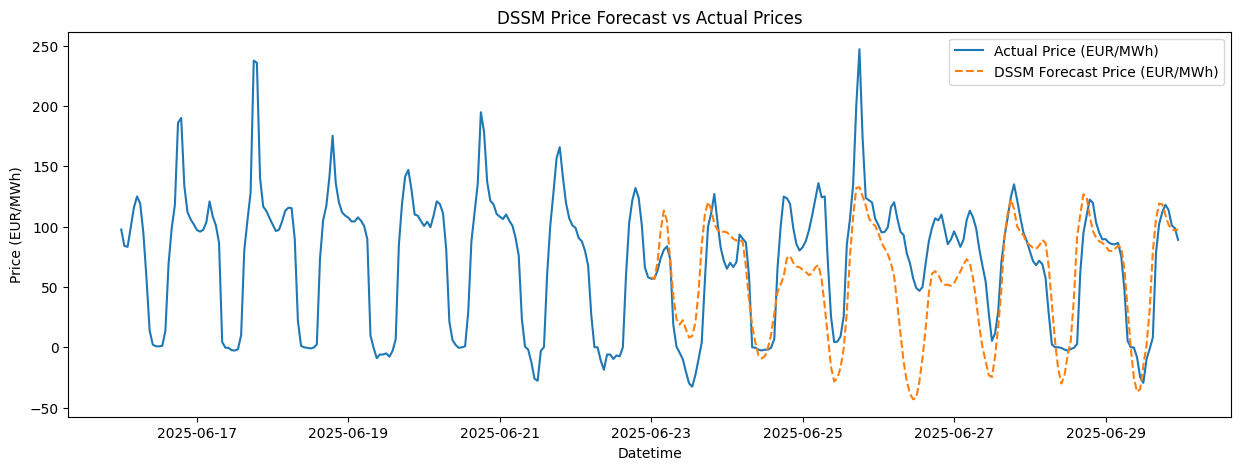

In [37]:
import sys
import pandas as pd
sys.path.append("../src")

from data.fetch_prices import get_energy_prices

df_prices = get_energy_prices("202506160000", "202506300000")

# plot vs predictions
plt.figure(figsize=(15, 5))
plt.plot(df_prices["datetime"], df_prices["price_EUR_MWh"], label="Actual Price (EUR/MWh)")
plt.plot(forecast_datetimes, forecast_unscaled, label="DSSM Forecast Price (EUR/MWh)", linestyle="--")
plt.title("DSSM Price Forecast vs Actual Prices")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()



# Evaluation

In [4]:
class DSSM(nn.Module):
    def __init__(self, input_dim, state_dim, hidden_dim, dropout, num_layers):
        super().__init__()
        self.rnn = nn.GRU(input_dim, state_dim, batch_first=True, num_layers=num_layers, dropout=dropout if num_layers > 1 else 0.0)
        self.obs_model = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        state_seq, _ = self.rnn(x)
        output = self.obs_model(state_seq[:, -1, :])
        return output.squeeze(-1)


--- Training model with dropout=0.1 ---
Epoch 1/30, Loss: 0.3531
Epoch 2/30, Loss: 0.2923
Epoch 3/30, Loss: 0.2409
Epoch 4/30, Loss: 0.2313
Epoch 5/30, Loss: 0.2040
Epoch 6/30, Loss: 0.1966
Epoch 7/30, Loss: 0.1879
Epoch 8/30, Loss: 0.1799
Epoch 9/30, Loss: 0.1843
Epoch 10/30, Loss: 0.2092
Epoch 11/30, Loss: 0.1813
Epoch 12/30, Loss: 0.1841
Epoch 13/30, Loss: 0.1708
Epoch 14/30, Loss: 0.1718
Epoch 15/30, Loss: 0.1744
Epoch 16/30, Loss: 0.2038
Epoch 17/30, Loss: 0.1742
Epoch 18/30, Loss: 0.1779
Epoch 19/30, Loss: 0.1660
Epoch 20/30, Loss: 0.1646
Epoch 21/30, Loss: 0.1667
Epoch 22/30, Loss: 0.1963
Epoch 23/30, Loss: 0.1674
Epoch 24/30, Loss: 0.1699
Epoch 25/30, Loss: 0.1577
Epoch 26/30, Loss: 0.1552
Epoch 27/30, Loss: 0.1599
Epoch 28/30, Loss: 0.1873
Epoch 29/30, Loss: 0.1609
Epoch 30/30, Loss: 0.1628

--- Training model with dropout=0.15 ---
Epoch 1/30, Loss: 0.3585
Epoch 2/30, Loss: 0.3025
Epoch 3/30, Loss: 0.2538
Epoch 4/30, Loss: 0.2419
Epoch 5/30, Loss: 0.2080
Epoch 6/30, Loss: 0.2

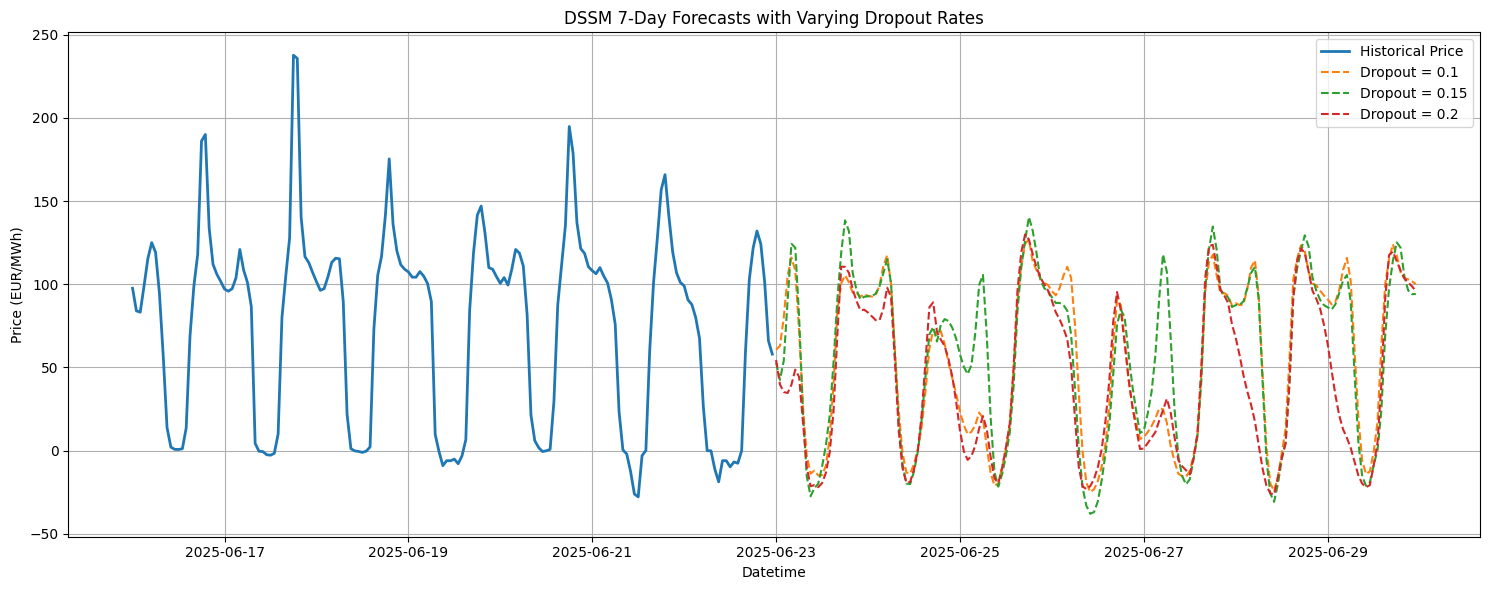

In [8]:
# ----- Data prep -----
sequence_length = 24
val_days = 30
val_size = val_days * 24

# Train/Val split
train_X = X[:-val_size]
train_y = y[:-val_size]
val_X = X[-val_size - sequence_length:]
val_y = y[-val_size - sequence_length:]

train_dataset = TimeSeriesDataset(train_X, train_y, sequence_length)
val_dataset = TimeSeriesDataset(val_X, val_y, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Forecast setup
forecast_horizon = 168
sequence_length = 168
weather_df = pd.read_csv("../data/weather_forecast.csv", parse_dates=["datetime"])
weather_df = weather_df.sort_values("datetime").reset_index(drop=True)

weather_features = ["temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation"]
scaler_weather = StandardScaler()
scaler_weather.fit(df[weather_features])
weather_df[weather_features] = scaler_weather.transform(weather_df[weather_features])

# ----- Main training & forecasting loop -----
n_epochs = 30
dropouts = [0.1, 0.15, 0.2]
predictions_dict = {}

for dropout in dropouts:
    print(f"\n--- Training model with dropout={dropout} ---")
    model = DSSM(input_dim=X.shape[1], state_dim=64, hidden_dim=128, dropout=dropout)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    criterion = nn.L1Loss()

    # Training
    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0
        for x, t in train_loader:
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, t.squeeze(-1))
            loss.backward()
            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Forecasting
    model.eval()
    forecast_scaled = []
    forecast_unscaled = []
    latest_features = df[features].iloc[-sequence_length:].copy()
    current_seq = torch.tensor(scaler_x.transform(latest_features), dtype=torch.float32).unsqueeze(0)

    for i in range(forecast_horizon):
        with torch.no_grad():
            pred_scaled = model(current_seq).item()
            forecast_scaled.append(pred_scaled)

        pred_unscaled = scaler_y.inverse_transform(np.array([[pred_scaled]]))[0, 0]
        forecast_unscaled.append(pred_unscaled)

        shifted_seq = current_seq[:, 1:, :].squeeze(0).numpy()
        next_feature = shifted_seq[-1].copy()

        new_datetime = df["datetime"].iloc[-1] + pd.Timedelta(hours=i + 1)
        idx_lag = features.index('price_lag_1h')
        next_feature[idx_lag] = pred_scaled
        idx_day = features.index('is_daytime')
        next_feature[idx_day] = 1 if 6 <= new_datetime.hour < 20 else 0
        idx_sin = features.index('sin_hour')
        idx_cos = features.index('cos_hour')
        next_feature[idx_sin] = np.sin(2 * np.pi * new_datetime.hour / 24)
        next_feature[idx_cos] = np.cos(2 * np.pi * new_datetime.hour / 24)

        weather_row = weather_df.loc[weather_df["datetime"] == new_datetime]
        if not weather_row.empty:
            for w_feat in weather_features:
                if w_feat in features:
                    next_feature[features.index(w_feat)] = weather_row.iloc[0][w_feat]
        else:
            print(f"No weather forecast for {new_datetime}, keeping last known values.")

        new_seq = np.vstack([shifted_seq, next_feature])
        current_seq = torch.tensor(new_seq, dtype=torch.float32).unsqueeze(0)

    predictions_dict[dropout] = forecast_unscaled

# ----- Plotting -----
forecast_datetimes = pd.date_range(
    start=df["datetime"].iloc[-1] + pd.Timedelta(hours=1),
    periods=forecast_horizon,
    freq="h"
)

plt.figure(figsize=(15, 6))
plt.plot(df["datetime"].iloc[-7*24:], df["price_EUR_MWh"].iloc[-7*24:], label="Historical Price", linewidth=2)

for dropout, forecast in predictions_dict.items():
    plt.plot(forecast_datetimes, forecast, label=f"Dropout = {dropout}", linestyle="--")

plt.title("DSSM 7-Day Forecasts with Varying Dropout Rates")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



--- Training DSSM with num_layers=1 ---
Epoch 1/30, Loss: 0.3362
Epoch 2/30, Loss: 0.2391
Epoch 3/30, Loss: 0.2168
Epoch 4/30, Loss: 0.2016
Epoch 5/30, Loss: 0.1843
Epoch 6/30, Loss: 0.1806
Epoch 7/30, Loss: 0.1707
Epoch 8/30, Loss: 0.1664
Epoch 9/30, Loss: 0.1712
Epoch 10/30, Loss: 0.1861
Epoch 11/30, Loss: 0.1662
Epoch 12/30, Loss: 0.1667
Epoch 13/30, Loss: 0.1611
Epoch 14/30, Loss: 0.1591
Epoch 15/30, Loss: 0.1606
Epoch 16/30, Loss: 0.1789
Epoch 17/30, Loss: 0.1590
Epoch 18/30, Loss: 0.1632
Epoch 19/30, Loss: 0.1523
Epoch 20/30, Loss: 0.1529
Epoch 21/30, Loss: 0.1537
Epoch 22/30, Loss: 0.1775
Epoch 23/30, Loss: 0.1537
Epoch 24/30, Loss: 0.1587
Epoch 25/30, Loss: 0.1499
Epoch 26/30, Loss: 0.1497
Epoch 27/30, Loss: 0.1483
Epoch 28/30, Loss: 0.1722
Epoch 29/30, Loss: 0.1489
Epoch 30/30, Loss: 0.1551

--- Training DSSM with num_layers=2 ---
Epoch 1/30, Loss: 0.3647
Epoch 2/30, Loss: 0.3170
Epoch 3/30, Loss: 0.2567
Epoch 4/30, Loss: 0.2437
Epoch 5/30, Loss: 0.2121
Epoch 6/30, Loss: 0.19

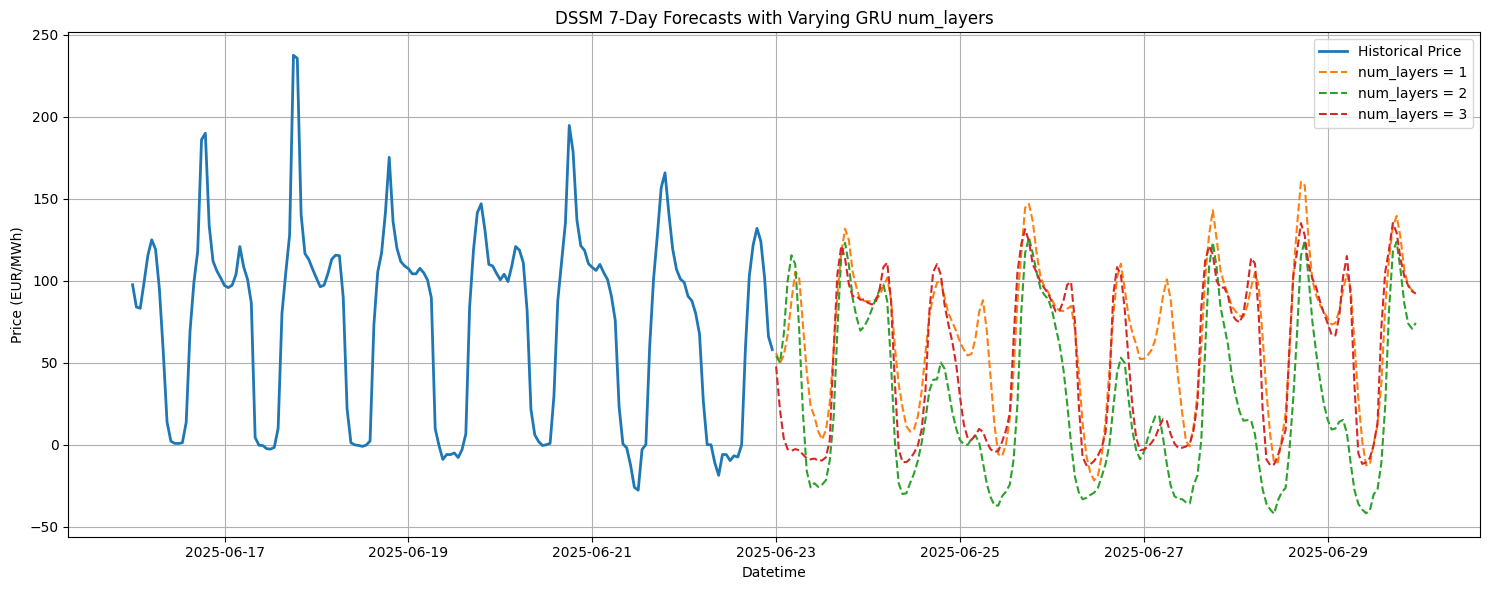

In [22]:
# ----- Data prep -----
sequence_length = 24
val_days = 30
val_size = val_days * 24

# Train/Val split
train_X = X[:-val_size]
train_y = y[:-val_size]
val_X = X[-val_size - sequence_length:]
val_y = y[-val_size - sequence_length:]

train_dataset = TimeSeriesDataset(train_X, train_y, sequence_length)
val_dataset = TimeSeriesDataset(val_X, val_y, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Forecast setup
forecast_horizon = 168
sequence_length = 168
weather_df = pd.read_csv("../data/weather_forecast.csv", parse_dates=["datetime"])
weather_df = weather_df.sort_values("datetime").reset_index(drop=True)

weather_features = ["temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation"]
scaler_weather = StandardScaler()
scaler_weather.fit(df[weather_features])
weather_df[weather_features] = scaler_weather.transform(weather_df[weather_features])

# ----- Training + Forecasting loop -----
n_epochs = 30
num_layers_list = [1, 2, 3]
dropout = 0.15  # Fixed dropout rate for GRU layers
forecast_horizon = 168
predictions_dict = {}

for num_layers in num_layers_list:
    print(f"\n--- Training DSSM with num_layers={num_layers} ---")
    model = DSSM(input_dim=X.shape[1], state_dim=64, hidden_dim=128, dropout=0.15, num_layers=num_layers)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    criterion = nn.L1Loss()

    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0
        for x, t in train_loader:
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, t.squeeze(-1))
            loss.backward()
            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Forecast
    model.eval()
    forecast_scaled = []
    forecast_unscaled = []
    latest_features = df[features].iloc[-sequence_length:].copy()
    current_seq = torch.tensor(scaler_x.transform(latest_features), dtype=torch.float32).unsqueeze(0)

    for i in range(forecast_horizon):
        with torch.no_grad():
            pred_scaled = model(current_seq).item()
            forecast_scaled.append(pred_scaled)
        pred_unscaled = scaler_y.inverse_transform(np.array([[pred_scaled]]))[0, 0]
        forecast_unscaled.append(pred_unscaled)

        shifted_seq = current_seq[:, 1:, :].squeeze(0).numpy()
        next_feature = shifted_seq[-1].copy()

        new_datetime = df["datetime"].iloc[-1] + pd.Timedelta(hours=i + 1)
        next_feature[features.index('price_lag_1h')] = pred_scaled
        next_feature[features.index('is_daytime')] = 1 if 6 <= new_datetime.hour < 20 else 0
        next_feature[features.index('sin_hour')] = np.sin(2 * np.pi * new_datetime.hour / 24)
        next_feature[features.index('cos_hour')] = np.cos(2 * np.pi * new_datetime.hour / 24)

        weather_row = weather_df.loc[weather_df["datetime"] == new_datetime]
        if not weather_row.empty:
            for w_feat in weather_features:
                if w_feat in features:
                    next_feature[features.index(w_feat)] = weather_row.iloc[0][w_feat]

        new_seq = np.vstack([shifted_seq, next_feature])
        current_seq = torch.tensor(new_seq, dtype=torch.float32).unsqueeze(0)

    predictions_dict[num_layers] = forecast_unscaled

# ----- Plotting -----
forecast_datetimes = pd.date_range(
    start=df["datetime"].iloc[-1] + pd.Timedelta(hours=1),
    periods=forecast_horizon,
    freq="h"
)

plt.figure(figsize=(15, 6))
plt.plot(df["datetime"].iloc[-7*24:], df["price_EUR_MWh"].iloc[-7*24:], label="Historical Price", linewidth=2)

for num_layers, forecast in predictions_dict.items():
    plt.plot(forecast_datetimes, forecast, label=f"num_layers = {num_layers}", linestyle="--")

plt.title("DSSM 7-Day Forecasts with Varying GRU num_layers")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# ----- Data prep -----
sequence_length = 24
val_days = 30
val_size = val_days * 24

# Train/Val split
train_X = X[:-val_size]
train_y = y[:-val_size]
val_X = X[-val_size - sequence_length:]
val_y = y[-val_size - sequence_length:]

train_dataset = TimeSeriesDataset(train_X, train_y, sequence_length)
val_dataset = TimeSeriesDataset(val_X, val_y, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Forecast setup
forecast_horizon = 168
sequence_length = 168
weather_df = pd.read_csv("../data/weather_forecast.csv", parse_dates=["datetime"])
weather_df = weather_df.sort_values("datetime").reset_index(drop=True)

weather_features = ["temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation"]
scaler_weather = StandardScaler()
scaler_weather.fit(df[weather_features])
weather_df[weather_features] = scaler_weather.transform(weather_df[weather_features])

# ----- Training & Forecasting Loop -----
n_epochs = 30
dropout = 0.15
hidden_dim = 128
num_layers = 2
state_dims = [32, 64, 128]
forecast_horizon = 168
sequence_length = 168
predictions_dict = {}

for state_dim in state_dims:
    print(f"\n--- Training DSSM with state_dim={state_dim} ---")
    model = DSSM(input_dim=X.shape[1], state_dim=state_dim, hidden_dim=hidden_dim, dropout=dropout, num_layers=num_layers)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    criterion = nn.L1Loss()

    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0
        for x, t in train_loader:
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, t.squeeze(-1))
            loss.backward()
            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Forecasting
    model.eval()
    forecast_scaled = []
    forecast_unscaled = []
    latest_features = df[features].iloc[-sequence_length:].copy()
    current_seq = torch.tensor(scaler_x.transform(latest_features), dtype=torch.float32).unsqueeze(0)

    for i in range(forecast_horizon):
        with torch.no_grad():
            pred_scaled = model(current_seq).item()
            forecast_scaled.append(pred_scaled)

        pred_unscaled = scaler_y.inverse_transform(np.array([[pred_scaled]]))[0, 0]
        forecast_unscaled.append(pred_unscaled)

        shifted_seq = current_seq[:, 1:, :].squeeze(0).numpy()
        next_feature = shifted_seq[-1].copy()

        new_datetime = df["datetime"].iloc[-1] + pd.Timedelta(hours=i + 1)
        next_feature[features.index('price_lag_1h')] = pred_scaled
        next_feature[features.index('is_daytime')] = 1 if 6 <= new_datetime.hour < 20 else 0
        next_feature[features.index('sin_hour')] = np.sin(2 * np.pi * new_datetime.hour / 24)
        next_feature[features.index('cos_hour')] = np.cos(2 * np.pi * new_datetime.hour / 24)

        weather_row = weather_df.loc[weather_df["datetime"] == new_datetime]
        if not weather_row.empty:
            for w_feat in weather_features:
                if w_feat in features:
                    next_feature[features.index(w_feat)] = weather_row.iloc[0][w_feat]

        new_seq = np.vstack([shifted_seq, next_feature])
        current_seq = torch.tensor(new_seq, dtype=torch.float32).unsqueeze(0)

    predictions_dict[state_dim] = forecast_unscaled

# ----- Plotting -----
forecast_datetimes = pd.date_range(
    start=df["datetime"].iloc[-1] + pd.Timedelta(hours=1),
    periods=forecast_horizon,
    freq="h"
)

plt.figure(figsize=(15, 6))
plt.plot(df["datetime"].iloc[-7*24:], df["price_EUR_MWh"].iloc[-7*24:], label="Historical Price", linewidth=2)

for state_dim, forecast in predictions_dict.items():
    plt.plot(forecast_datetimes, forecast, label=f"state_dim = {state_dim}", linestyle="--")

plt.title("DSSM 7-Day Forecasts with Varying GRU state_dim")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()